In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib import style
# style.use('dark_background')

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

import util

In [ ]:
def model_evaluation_CV(mdl, df, train_df, feature_col, n=4,
    normalize=True, detail_pred=False, plot_roc=False):
    # Evaluate model accuracy using Stratified K-fold CV
    # Note: Stratification is based on patient group (A, B, C), and then samples are formed
    skf = StratifiedKFold(n_splits=n)
    acc_train, acc_val = [], []

    if detail_pred:
        patient_pred = train_df.copy(deep=True).set_index('file')
        patient_pred.rename(columns={'group': 'true'}, inplace=True)
        seg_pred = {}

    if plot_roc:
        tprs, aucs = [], []
        mean_fpr = np.linspace(0, 1, 100)
        _, ax = plt.subplots()
    
    for idx_train, idx_val in skf.split(train_df, train_df['group']):
        file_train, file_val = train_df.loc[idx_train, 'file'], train_df.loc[idx_val, 'file']
        X_train, y_train = df.loc[df.file.isin(file_train), feature_col], df.loc[df.file.isin(file_train), 'apn']
        X_val, y_val = df.loc[df.file.isin(file_val), feature_col], df.loc[df.file.isin(file_val), 'apn']
        
        if normalize:
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)

        mdl.fit(X_train, y_train)
        acc_train.append(metrics.accuracy_score(y_train, mdl.predict(X_train)))
        acc_val.append(metrics.accuracy_score(y_val, mdl.predict(X_val)))
        
        if plot_roc:
            viz = metrics.plot_roc_curve(mdl, X_val, y_val,
                                alpha=0.3, lw=1, ax=ax)
            interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)
            
        # Accuracy for group diagnosis
        if detail_pred:
            for file in file_val:
                X_val, y_val = df.loc[df.file.isin([file]), feature_col], df.loc[df.file.isin([file]), 'apn']
                X_val = scaler.transform(X_val) if normalize else X_val
                y_pred = mdl.predict(X_val)
                y_pred_prob = mdl.predict_proba(X_val)
                patient_pred.loc[file,'pred']=ecg_diagnose(y_pred)
                seg_pred[file] = np.vstack((y_val, y_pred, y_pred_prob[:, 1]))
    
    if plot_roc:        
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = metrics.auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        ax.legend(loc="lower right")
        plt.show()

    res_detail = {}
    if detail_pred:
        res_detail['patient_pred'] = patient_pred
        res_detail['seg_pred'] = seg_pred
    if plot_roc:
        res_detail['mean_fpr'] = mean_fpr
        res_detail['mean_tpr'] = mean_tpr
        res_detail['mean_auc'] = mean_auc
    
    return np.mean(acc_train), np.mean(acc_val), res_detail


In [16]:
print(minute_auc, group_f1_macro, grouop_auc_macro)

0.877913740847086 0.5566261695293954 0.9330078125000001


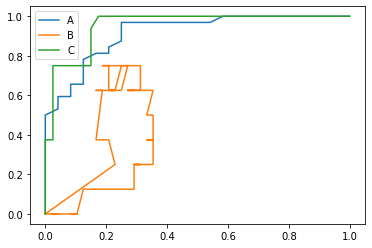

In [73]:
plt.plot(multiclass_auc['fpr_A'], multiclass_auc['tpr_A'], label='A')
plt.plot(multiclass_auc['fpr_B'], multiclass_auc['tpr_B'], label='B')
plt.plot(multiclass_auc['fpr_C'], multiclass_auc['tpr_C'], label='C')
plt.legend()
plt.show()

In [3]:
# Baseline model
logreg_1 = LogisticRegression(solver='lbfgs', max_iter=1e6)
acc_train, acc_val = util.model_evaluation_CV(logreg_1, df, train_df, feature_col, normalize=True)
print(f'Baseline performance: {acc_train:.3f} for training, {acc_val:.3f} for validation')

# Baseline model + L1 (C=0.01)
logreg_2 = LogisticRegression(C=0.01, penalty="l1", dual=False, solver='saga', max_iter=1e6)
acc_train, acc_val = util.model_evaluation_CV(logreg_2, df, train_df, feature_col, normalize=True)
print(f'With L1 (C=0.01): {acc_train:.3f} for training, {acc_val:.3f} for validation')

# Baseline model + L1 (C=1)
logreg_3 = LogisticRegression(C=1, penalty="l1", dual=False, solver='saga', max_iter=1e6)
acc_train, acc_val = util.model_evaluation_CV(logreg_3, df, train_df, feature_col, normalize=True)
print(f'With L1 (C=1): {acc_train:.3f} for training, {acc_val:.3f} for validation')

# SVC baseline
lsvc = LinearSVC(max_iter=1e6)
acc_train, acc_val = util.model_evaluation_CV(lsvc, df, train_df, feature_col, normalize=True)
print(f'Baseline for Linear SVC: {acc_train:.3f} for training, {acc_val:.3f} for validation')

# SVC (C=0.01)
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=1e6)
acc_train, acc_val = util.model_evaluation_CV(lsvc, df, train_df, feature_col, normalize=True)
print(f'Linear SVC (C=0.01): {acc_train:.3f} for training, {acc_val:.3f} for validation')


Baseline performance: 0.858 for training, 0.827 for validation
With L1 (C=0.01): 0.843 for training, 0.818 for validation
With L1 (C=1): 0.858 for training, 0.827 for validation
Baseline for Linear SVC: 0.858 for training, 0.827 for validation
Linear SVC (C=0.01): 0.853 for training, 0.828 for validation
